### Binary period with LS-periodogram

We want to check how sensitive LS-p is to eccentricity of a binary system while estimating the true period of the binary.


To do this exercise, we will simulate two systems with identical orbitral parameters except the eccentricity. We will set one system to be completely circular while the other to be somewhat eccentric.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from astropy.timeseries import LombScargle

In [7]:
def eccentric_anomaly(M, e):
    return fsolve(lambda E: E - e * np.sin(E) - M, M)

# Function to compute true anomaly from eccentric anomaly
def true_anomaly(E, e):
    return 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))

# Radial velocity as a function of time
def radial_velocity(t, K, P, e, omega, T0):
    M = 2 * np.pi / P * (t - T0)  # Mean anomaly
    if e == 0:
        return K * np.cos(M)
    else:
        E = eccentric_anomaly(M, e)  # Eccentric anomaly
        nu = true_anomaly(E, e)      # True anomaly
        return K * (np.cos(nu + omega) + e * np.cos(omega))

def periodogram_analysis(t, rv):
    # Calculate sampling rate and Nyquist frequency
    dt = np.median(np.diff(t))
    nyquist_freq = 0.5 / dt
    max_period = 20  # Maximum period to search (in days)
    
    #frequency range: between Nyquist and 1/15 days
    frequency, power = LombScargle(t, rv).autopower(
        minimum_frequency=1/max_period,
        maximum_frequency=nyquist_freq
    )
    
    best_period = 1 / frequency[np.argmax(power)]
    fap = LombScargle(t, rv).false_alarm_probability(power.max())
    return frequency, power, best_period, fap


### simulate a RV curve given different eccentricity

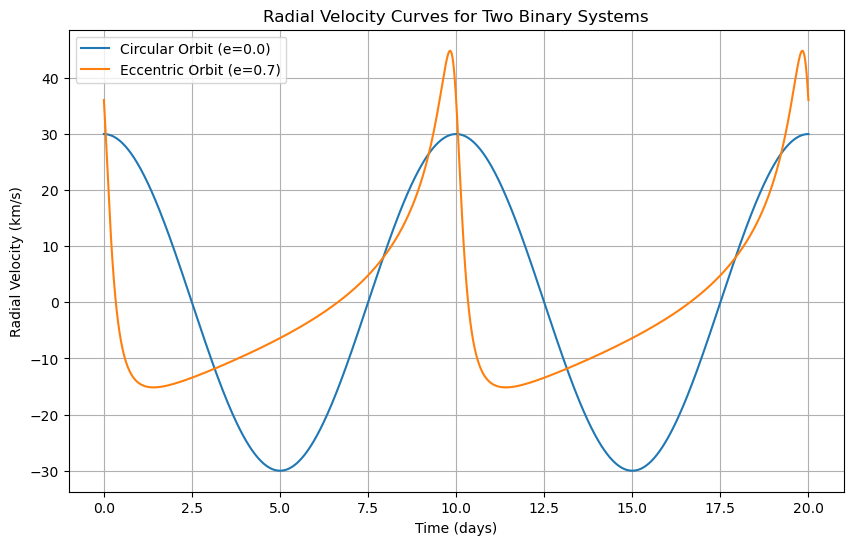

In [5]:
P = 10.0  # Period in days
K = 30.0  # Semi-amplitude in km/s
T0 = 0.0  # Time of periastron passage in days
omega = np.radians(45.0)  # Argument of periastron in radians

e1 = 0.0
e2 = 0.7
t = np.linspace(0, 2*P, 1000)
rv1 = radial_velocity(t, K, P, e1, omega, T0)
rv2 = radial_velocity(t, K, P, e2, omega, T0)

plt.figure(figsize=(10, 6))
plt.plot(t, rv1, label=f'Circular Orbit (e={e1})')
plt.plot(t, rv2, label=f'Eccentric Orbit (e={e2})')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Curves for Two Binary Systems')
plt.legend()
plt.grid(True)
plt.show()

### LSP on the simulated RVs as true RV to estimate observed period

In [8]:
freq1, power1, P_best1, fap1 = periodogram_analysis(t, rv1)
freq2, power2, P_best2, fap2 = periodogram_analysis(t, rv2)

rv_model1 = radial_velocity(t, K, P_best1, e1, omega, T0)
rv_model2 = radial_velocity(t, K, P_best2, e2, omega, T0)
residuals1 = rv1 - rv_model1
residuals2 = rv2 - rv_model2

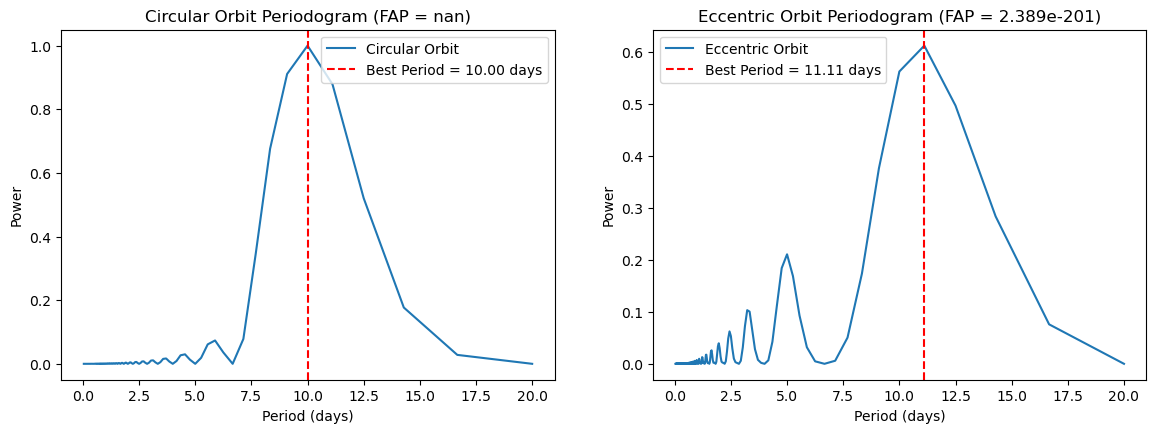

In [9]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(1/freq1, power1, label='Circular Orbit')
plt.axvline(P_best1, color='r', linestyle='--', label=f'Best Period = {P_best1:.2f} days')
plt.title(f'Circular Orbit Periodogram (FAP = {fap1:.3e})')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(1/freq2, power2, label='Eccentric Orbit')
plt.axvline(P_best2, color='r', linestyle='--', label=f'Best Period = {P_best2:.2f} days')
plt.title(f'Eccentric Orbit Periodogram (FAP = {fap2:.3e})')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend()

LSP seems to retrive the true period of the circular orbit pretty well, while for the eccentric system, it overestimates the period by 10% 

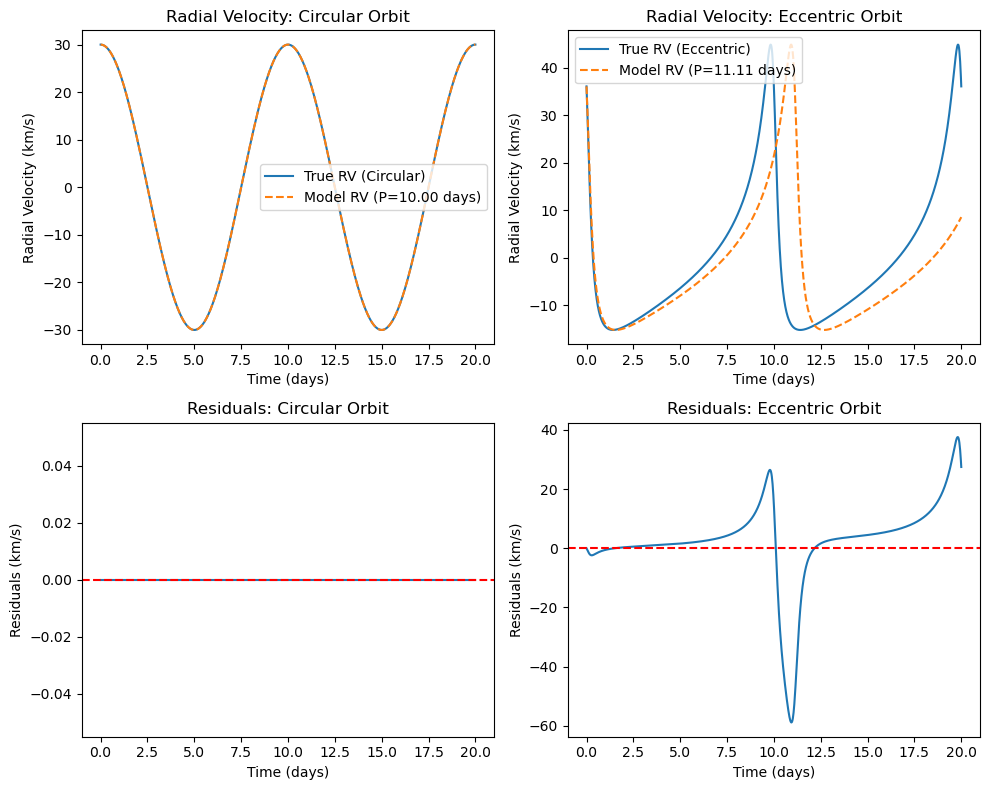

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(t, rv1, label='True RV (Circular)')
plt.plot(t, rv_model1, label=f'Model RV (P={P_best1:.2f} days)', linestyle='--')
plt.title('Radial Velocity: Circular Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t, rv2, label='True RV (Eccentric)')
plt.plot(t, rv_model2, label=f'Model RV (P={P_best2:.2f} days)', linestyle='--')
plt.title('Radial Velocity: Eccentric Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(t, residuals1, label='Residuals (Circular)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals: Circular Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Residuals (km/s)')

plt.subplot(2, 2, 4)
plt.plot(t, residuals2, label='Residuals (Eccentric)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals: Eccentric Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Residuals (km/s)')

plt.tight_layout()
plt.show()

### try to simulate real enough! data to see how LSP fares with it.

We will try to introduce typical RV errors on the true (simulated) RVs

We also need some gaps in the data to imitate real data

We will set the period to P = 9 days. But the idea is to check this on different periods and see if that has an affect

In [35]:
def add_noise(rv, noise_std):
    return rv + np.random.normal(0, noise_std, size=len(rv))

#introduce random gaps in the time array and corresponding RV data
def introduce_random_gaps(t, rv, gap_fraction=0.2):
    num_gaps = int(len(t) * gap_fraction)
    gap_indices = np.random.choice(len(t), num_gaps, replace=False)
    mask = np.ones(len(t), dtype=bool)
    mask[gap_indices] = False
    return t[mask], rv[mask]

In [32]:
P_true = 9 #days

rv1_true = radial_velocity(t, K, P_true, e1, omega, T0)  # Circular orbit
rv2_true = radial_velocity(t, K, P_true, e2, omega, T0)  # Eccentric orbit


noise_std = 2.0
rv1_noisy = add_noise(rv1_true, noise_std)
rv2_noisy = add_noise(rv2_true, noise_std)
t_gapped1, rv1_gapped = introduce_random_gaps(t, rv1_noisy, gap_fraction=0.6)
t_gapped2, rv2_gapped = introduce_random_gaps(t, rv2_noisy, gap_fraction=0.7)

# Lomb-Scargle Periodogram for both systems
freq1, power1, P_best1, fap1 = periodogram_analysis(t_gapped1, rv1_gapped)
freq2, power2, P_best2, fap2 = periodogram_analysis(t_gapped2, rv2_gapped)

rv_model1 = radial_velocity(t_gapped1, K, P_best1, e1, omega, T0)
rv_model2 = radial_velocity(t_gapped2, K, P_best2, e2, omega, T0)
residuals1 = rv1_gapped - rv_model1
residuals2 = rv2_gapped - rv_model2


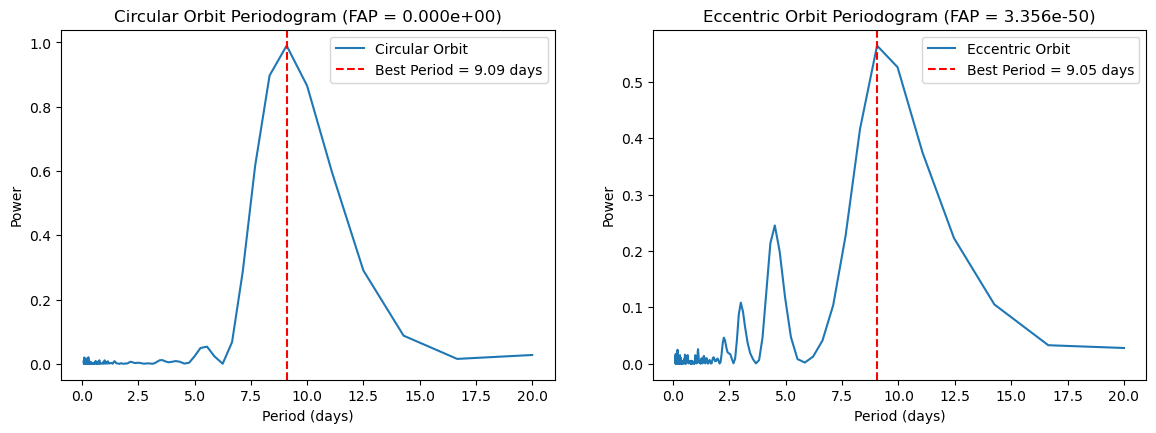

In [33]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(1/freq1, power1, label='Circular Orbit')
plt.axvline(P_best1, color='r', linestyle='--', label=f'Best Period = {P_best1:.2f} days')
plt.title(f'Circular Orbit Periodogram (FAP = {fap1:.3e})')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(1/freq2, power2, label='Eccentric Orbit')
plt.axvline(P_best2, color='r', linestyle='--', label=f'Best Period = {P_best2:.2f} days')
plt.title(f'Eccentric Orbit Periodogram (FAP = {fap2:.3e})')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend()

Seems like both periodogram retrives the period pretty well for both the systems [moderate error of <5% and <9%]

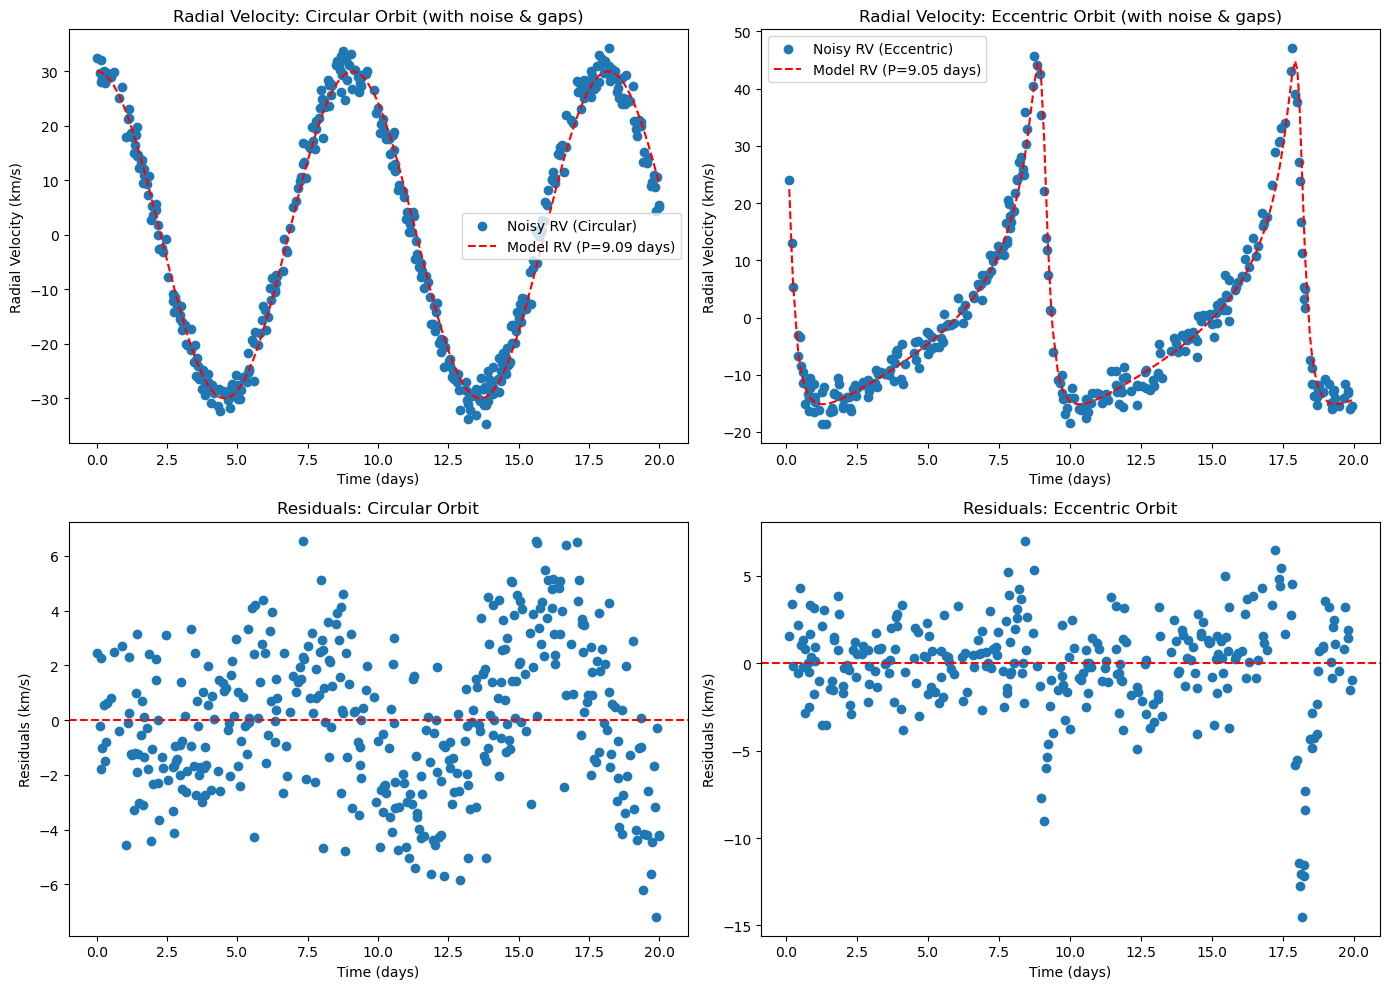

In [34]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.scatter(t_gapped1, rv1_gapped, label='Noisy RV (Circular)')
plt.plot(t_gapped1, rv_model1, 'r--', label=f'Model RV (P={P_best1:.2f} days)')
plt.title('Radial Velocity: Circular Orbit (with noise & gaps)')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(t_gapped2, rv2_gapped, label='Noisy RV (Eccentric)')
plt.plot(t_gapped2, rv_model2, 'r--', label=f'Model RV (P={P_best2:.2f} days)')
plt.title('Radial Velocity: Eccentric Orbit (with noise & gaps)')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.legend()

# Plot residuals
plt.subplot(2, 2, 3)
plt.scatter(t_gapped1, residuals1, label='Residuals (Circular)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals: Circular Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Residuals (km/s)')

plt.subplot(2, 2, 4)
plt.scatter(t_gapped2, residuals2, label='Residuals (Eccentric)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals: Eccentric Orbit')
plt.xlabel('Time (days)')
plt.ylabel('Residuals (km/s)')

plt.tight_layout()
plt.show()

LSP leaves big residuals at the kink on the RV curve due to eccentricity. Otherwise, LSP seem to work pretty well for both type of systems